In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import (running_mean_APWP, running_mean_APWP_shape, RM_stats, get_pseudo_vgps, get_vgps_sampling_direction, 
                                  running_mean_VGPs_bootstrapped, running_mean_bootstrapping_direction)

from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles
np.random.seed(0)

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True) # takes as many as poles as are described for one are

## Set the hyperparameters for further comparissons.

In [4]:
min_age = 0
max_age = 65
window_length = 15
time_step = 5
# define a list to store all the models
models = []

### 1. Running means classic approach on poles

In [5]:
RM_1_classic_by_study = running_mean_APWP (df_pole_compilation, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_1_classic_by_study['method'] = "RM_classic"
models.append(RM_1_classic_by_study)
RM_1_classic_by_study.head(5)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,12.0,12.0,135.172992,3.746692,6.966908,-77.850084,-86.746017,RM_classic
1,5.0,15.0,15.0,157.806367,3.053286,6.447966,-67.163587,-87.015353,RM_classic
2,10.0,6.0,6.0,227.312026,4.453474,5.372468,-79.156412,-88.237442,RM_classic
3,15.0,4.0,4.0,634.387048,3.650730,3.215939,-21.810052,-86.038002,RM_classic
4,20.0,3.0,3.0,614.606390,4.976959,3.267281,-18.481366,-82.522049,RM_classic


### 2. Running means ensemble from pseudo-VGPs approach (Vaes et al. 2022)

In [6]:
%%time
RM_2_ensemble_pseudoVGP = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):   
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP_shape(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i

    RM_2_ensemble_pseudoVGP = RM_2_ensemble_pseudoVGP.append(RM_APWP_parametric_temp, ignore_index=True)
RM_2_ensemble_pseudoVGP['plon'] = RM_2_ensemble_pseudoVGP.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)    
RM_2_ensemble_pseudoVGP['method'] = "RM_pseudoVGPs_ensemble"
models.append(RM_2_ensemble_pseudoVGP)

CPU times: user 24.5 s, sys: 104 ms, total: 24.6 s
Wall time: 24.6 s


Set quantiles

In [7]:
RM_2_quantiles_plat = quantiles(RM_2_ensemble_pseudoVGP,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_2_quantiles_plon = quantiles(RM_2_ensemble_pseudoVGP,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_2_ensemble_pseudoVGP.head(3)

,run,n_studies,k,A95,csd,age,N,plon,plat,foliation,lineation,collinearity,coplanarity,method
0,0,15.0,25.166251,1.703345,16.146402,0.0,282.0,-20.395705,-86.811723,0.098303,0.540832,5.501684,0.639135,RM_pseudoVGPs_ensemble
1,0,15.0,24.695898,1.594399,16.299437,5.0,328.0,-16.243970,-86.744727,0.062254,0.536100,8.611432,0.598355,RM_pseudoVGPs_ensemble
2,0,10.0,18.591607,2.332397,18.785664,10.0,207.0,-3.015192,-87.193589,0.172906,0.371808,2.150347,0.544714,RM_pseudoVGPs_ensemble


## 3. Running means on VGPs. 
Three different approachs as follows:
### 3.1. Running means on the computed dataset (one run and A95)

In [8]:
RM_31_on_VGP = running_mean_APWP(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
RM_31_on_VGP['method'] = "RM_classic_VGPs"
models.append(RM_31_on_VGP)

In [9]:
RM_31_on_VGP.head(3)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,283.0,15.0,23.737437,1.752923,16.625247,-45.869508,-88.098726,RM_classic_VGPs
1,5.0,308.0,15.0,22.847346,1.713794,16.945998,-45.430085,-88.076649,RM_classic_VGPs
2,10.0,161.0,9.0,20.924372,2.487633,17.707563,-46.191588,-87.489859,RM_classic_VGPs


### 3.2. Running means on random samples (with replacement) from the original dataset to generate an ensemble of possible solution.

In [10]:
%%time
RM_32_boots_VGPs=running_mean_VGPs_bootstrapped(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_32_boots_VGPs['method']="RM_bootstrapped_VGPs_ensemble"
models.append(RM_32_boots_VGPs)

CPU times: user 10.4 s, sys: 82.2 ms, total: 10.5 s
Wall time: 10.5 s


Set quantiles

In [11]:
RM_32_quantiles_plat = quantiles(RM_32_boots_VGPs,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_32_quantiles_plon = quantiles(RM_32_boots_VGPs,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_32_boots_VGPs.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,291.0,23.109803,1.752895,16.849495,0.177638,0.718905,4.047023,0.896543,0.0,14.0,-54.934468,-87.609392,RM_bootstrapped_VGPs_ensemble
1,0.0,309.0,22.827044,1.711801,16.953532,0.185288,0.697438,3.764073,0.882726,5.0,14.0,-52.950440,-87.724472,RM_bootstrapped_VGPs_ensemble
2,0.0,159.0,20.444298,2.534087,17.914262,0.317275,0.656406,2.06889,0.973681,10.0,9.0,-58.550039,-88.768761,RM_bootstrapped_VGPs_ensemble


### 3.3. Propation of directional error towards the VGP level. 
We take the original directions as a PDF to generate to generate a pseudo-Dataset that incorporates the uncertinty in the directional space and time. We aaply the running means on a number of $pseudo$-VGPs to generate an ensemble of possible paths

In [12]:
%%time
RM_33_propagation=running_mean_bootstrapping_direction(df_filtered_vgps,'plon', 'plat', 'age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_33_propagation['method']="RM_DirErrorPropagated_ensemble"
models.append(RM_33_propagation)

CPU times: user 42 s, sys: 229 ms, total: 42.3 s
Wall time: 42.4 s


Set quantiles

In [13]:
RM_33_quantiles_plat = quantiles(RM_33_propagation,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_33_quantiles_plon = quantiles(RM_33_propagation,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_33_propagation.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,269.0,21.202573,1.907676,17.591008,0.102961,0.707398,6.870577,0.810359,0.0,13.0,-91.496388,-88.138779,RM_DirErrorPropagated_ensemble
1,0.0,296.0,20.864482,1.833537,17.732959,0.056769,0.733728,12.924699,0.790497,5.0,13.0,-84.905119,-87.792021,RM_DirErrorPropagated_ensemble
2,0.0,130.0,16.422256,3.150041,19.987966,0.149163,0.581923,3.901257,0.731086,10.0,10.0,-58.564149,-85.375445,RM_DirErrorPropagated_ensemble


## Get APW from Muller et al., 2016 and Torsvik and Cocks, 2017

- Müller, R. D., Seton, M., Zahirovic, S., Williams, S. E., Matthews, K. J., Wright, N. M., ... & Cannon, J. (2016). Ocean basin evolution and global-scale plate reorganization events since Pangea breakup. Annual Review of Earth and Planetary Sciences, 44, 107-138. DOI:10.1146/annurev-earth-060115-012211
- Torsvik, T. H., & Cocks, L. R. M. (2013). Gondwana from top to base in space and time. Gondwana Research, 24(3-4), 999-1030.


In [14]:
Torsvik2017_path = np.loadtxt('model_APWP/code_output/NAM_0_60_torsvik_2017.txt', )
Torsvik2017_path_df = pd.DataFrame(Torsvik2017_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Torsvik2017_path_df = Torsvik2017_path_df[Torsvik2017_path_df['age']>0]
Torsvik2017_path_df['method'] = "plate model"
models.append(Torsvik2017_path_df)

Mueller2016_path = np.loadtxt('model_APWP/code_output/NAM_0_60_muller_2016.txt', )
Mueller2016_path_df = pd.DataFrame(Mueller2016_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Mueller2016_path_df = Mueller2016_path_df[Mueller2016_path_df['age']>0]
Mueller2016_path_df['method']="plate model"
models.append(Mueller2016_path_df)

Merge

In [15]:
df_all = pd.concat(models, axis=0)
df_all.head()

,age,N,n_studies,k,A95,csd,plon,plat,method,run,foliation,lineation,collinearity,coplanarity,Euler_angle,Euler_lon,Euler_lat
0,0.0,12.0,12.0,135.172992,3.746692,6.966908,-77.850084,-86.746017,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,15.0,15.0,157.806367,3.053286,6.447966,-67.163587,-87.015353,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,6.0,6.0,227.312026,4.453474,5.372468,-79.156412,-88.237442,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.0,4.0,4.0,634.387048,3.65073,3.215939,-21.810052,-86.038002,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20.0,3.0,3.0,614.60639,4.976959,3.267281,-18.481366,-82.522049,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Comparisons plot

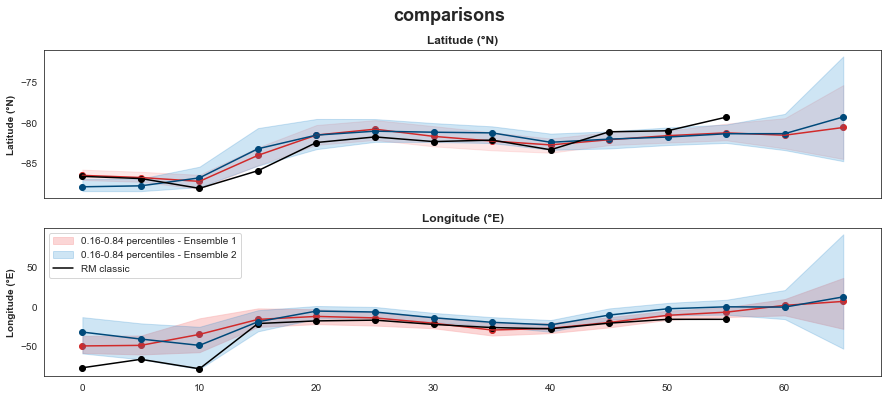

In [16]:
title = "comparisons"

ensemble1_lon = RM_2_quantiles_plon
ensemble1_lat = RM_2_quantiles_plat

ensemble2_lat = RM_33_quantiles_plat
ensemble2_lon = RM_33_quantiles_plon

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')
# LATITUDE
# axes[0].scatter(RM_ensemble_pseudoVGP['age'],RM_ensemble_pseudoVGP['plat'], s = 1, color = 'black', alpha = 0.2)
# axes[0].fill_between(ensemble1_lat.X, ensemble1_lat.q5,ensemble1_lat.q95, color= "#f9afaf", alpha=.20,label="Running mean on VGPs ensemble")
axes[0].fill_between(ensemble1_lat.X, ensemble1_lat.q16,ensemble1_lat.q84, color= "#f98787", alpha=.20)
# axes[0].plot(a.X, a.mean, '--', color="#ad3131",label="mean")
axes[0].plot(ensemble1_lat.X, ensemble1_lat.q50, '-',color="#d12a2a")
axes[0].scatter(ensemble1_lat.X, ensemble1_lat.q50,color="#d12a2a")

# axes[0].scatter(RM_ensemble_VGPs['age'],RM_ensemble_VGPs['plat'], s = 1, color = 'black', alpha = 0.2)
# axes[0].fill_between(ensemble2_lat.X, ensemble2_lat.q5,ensemble2_lat.q95, color= "#1CA0F9", alpha=.20,label="Running mean on $pseudo$-VGPs")
axes[0].fill_between(ensemble2_lat.X, ensemble2_lat.q16,ensemble2_lat.q84, color= "#0E7DC9", alpha=.20)
# axes[0].plot(a.X, a.mean, '--', color="#ad3131",label="mean")
axes[0].plot(ensemble2_lat.X, ensemble2_lat.q50, '-',color="#00497A")
axes[0].scatter(ensemble2_lat.X, ensemble2_lat.q50,color="#00497A")

axes[0].plot(RM_1_classic_by_study.age, RM_1_classic_by_study.plat, '-',color="black") #CLASSIC
axes[0].scatter(RM_1_classic_by_study.age, RM_1_classic_by_study.plat, color="black") #CLASSIC

# LONGITUDE
#axes[1].scatter(RM_ensemble_VGPs['age'],RM_ensemble_VGPs['plon'], s = 1, color = 'black', alpha = 0.2)
axes[1].fill_between(ensemble1_lon.X, ensemble1_lon.q16,ensemble1_lon.q84, color= "#f9afaf", alpha=.50,label="0.16-0.84 percentiles - Ensemble 1")
# axes[1].fill_between(ensemble1_lon.X, ensemble1_lon.q25,ensemble1_lon.q75, color= "#f98787", alpha=.20, label="Running mean on $pseudo$-VGPs")
# axes[1].plot(a.X, a.mean, '--', color="#ad3131",label="mean")
axes[1].plot(ensemble1_lon.X, ensemble1_lon.q50, '-',color="#d12a2a")
axes[1].scatter(ensemble1_lon.X, ensemble1_lon.q50,color="#d12a2a")

# axes[0].scatter(RM_ensemble_VGPs['age'],RM_ensemble_VGPs['plat'], s = 1, color = 'black', alpha = 0.2)
# axes[1].fill_between(ensemble2_lon.X, ensemble2_lon.q5,ensemble2_lon.q95, color= "#1CA0F9", alpha=.20)
axes[1].fill_between(ensemble2_lon.X, ensemble2_lon.q16,ensemble2_lon.q84, color= "#0E7DC9", alpha=.20,label="0.16-0.84 percentiles - Ensemble 2")
# axes[0].plot(a.X, a.mean, '--', color="#ad3131",label="mean")
axes[1].plot(ensemble2_lon.X, ensemble2_lon.q50, '-',color="#00497A", zorder =2)
axes[1].scatter(ensemble2_lon.X, ensemble2_lon.q50,  color = "#00497A", alpha = 1, zorder =3)

axes[1].plot(RM_1_classic_by_study.age, RM_1_classic_by_study.plon, '-',color="black", label = "RM classic") #CLASSIC
axes[1].scatter(RM_1_classic_by_study.age, RM_1_classic_by_study.plon, color="black") #CLASSIC

# axes[1].set_ylim(-100, 50)
plt.legend(loc="upper left")

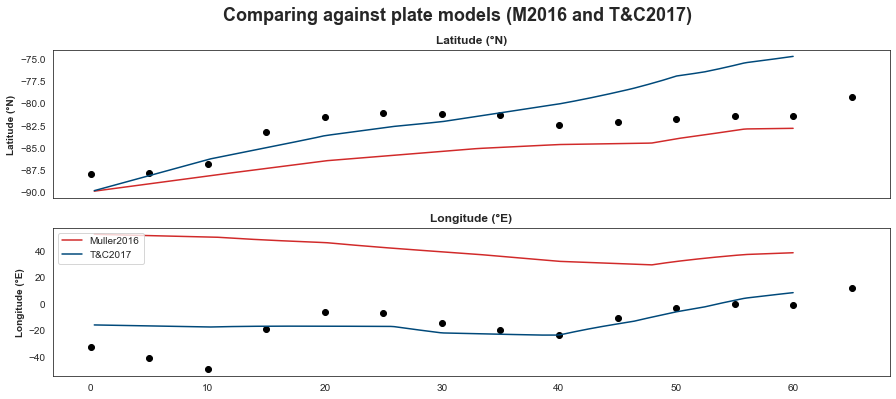

In [17]:
title = "Comparing against plate models (M2016 and T&C2017)"

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')
# LATITUDE

axes[0].plot(Mueller2016_path_df.age, Mueller2016_path_df.plat, '-',color="#d12a2a")
# axes[0].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plat,s = 1, color="#d12a2a")
axes[0].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, '-',color="#00497A") #CLASSIC
# axes[0].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, color="#00497A") #CLASSIC
axes[0].scatter(ensemble2_lat.X, ensemble2_lat.q50,color="black")
# LONGITUDE

axes[1].plot(Mueller2016_path_df.age, Mueller2016_path_df.plon, '-',color="#d12a2a", label = "Muller2016")
# axes[1].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plon,color="#d12a2a")
axes[1].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, '-',color="#00497A", label = "T&C2017") #CLASSIC
# axes[1].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, color="#00497A") #CLASSIC
axes[1].scatter(ensemble2_lon.X, ensemble2_lon.q50,color="black")

# axes[1].set_ylim(-100, 50)
plt.legend(loc="upper left")

In [18]:
from vgptools.auxiliar import eigen_decomposition

class PC:
    
    '''
    Class to calculate PCs as a function of time from a time dependant ensemble of directions
    '''
    def __init__(self, df, xlabel, LatLabel, LonLabel):
        
        self.X = df[xlabel].unique().transpose()
        self.df=df
        self.xlabel=xlabel
        self.LatLabel=LatLabel
        self.LonLabel=LonLabel
        self.groupby=df.groupby(xlabel)
        
    def PC(self):
        lats, lons = [], []
        for age, df_age in self.groupby:
            array = np.array([spherical2cartesian([ np.radians(i[self.LonLabel]),np.radians(i[self.LatLabel])]) for _,i in df_age.iterrows()])
            eigenValues, eigenVectors = eigen_decomposition(array)
            print(np.degrees(cartesian2spherical(eigenVectors[:,0])), age, len(array))
        return [np.array(lats),np.array(lons)]

In [19]:
PC(RM_32_boots_VGPs,"age","plat","plon").PC()

[-46.3064564944848  -87.80583010024577] 0.0 100
[-45.99287362570681 -87.79225479127157] 5.0 100
[-46.555978298539486 -87.12089346805396 ] 10.0 100
[-14.546738466253293 -83.2370179747668  ] 15.0 100
[ -6.746545347049646 -81.20699737267672 ] 20.0 100
[-14.979753817424696 -81.18159064289767 ] 25.0 100
[-20.37923441020529 -81.84927333668742] 30.0 100
[-28.939941364587188 -82.01507871846776 ] 35.0 100
[-30.275361470174   -82.81071225214758] 40.0 100
[-19.2903882186058  -81.91365855198478] 45.0 100
[-13.80619128200469 -81.17326763741802] 50.0 100
[ -9.06152962544572 -81.17454717787477] 55.0 100
[  3.770125755067685 -81.06840458712398 ] 60.0 100
[ 64.39157657537075 -81.238280351309  ] 65.0 100


[array([], dtype=float64), array([], dtype=float64)]

In [20]:
RM_33_propagation
RM_32_boots_VGPs

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,291.0,23.109803,1.752895,16.849495,0.177638,0.718905,4.047023,0.896543,0.0,14.0,-54.934468,-87.609392,RM_bootstrapped_VGPs_ensemble
1,0.0,309.0,22.827044,1.711801,16.953532,0.185288,0.697438,3.764073,0.882726,5.0,14.0,-52.950440,-87.724472,RM_bootstrapped_VGPs_ensemble
2,0.0,159.0,20.444298,2.534087,17.914262,0.317275,0.656406,2.06889,0.973681,10.0,9.0,-58.550039,-88.768761,RM_bootstrapped_VGPs_ensemble
3,0.0,63.0,14.973783,4.783091,20.932411,0.305627,0.340017,1.11252,0.645644,15.0,7.0,-25.077597,-83.128644,RM_bootstrapped_VGPs_ensemble
4,0.0,133.0,10.14031,4.044485,25.43662,0.23203,0.474333,2.044277,0.706363,20.0,7.0,-14.805770,-82.273687,RM_bootstrapped_VGPs_ensemble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,99.0,291.0,18.234489,1.985383,18.968728,0.198377,0.435742,2.196537,0.634118,45.0,10.0,-16.130575,-81.572386,RM_bootstrapped_VGPs_ensemble
1396,99.0,255.0,16.902633,2.208715,19.701887,0.127609,0.37349,2.926837,0.501099,50.0,8.0,-13.953657,-80.667848,RM_bootstrapped_VGPs_ensemble
1397,99.0,215.0,17.012987,2.398413,19.637886,0.0539,0.455666,8.453921,0.509566,55.0,5.0,-13.591928,-79.590728,RM_bootstrapped_VGPs_ensemble
1398,99.0,45.0,13.921925,5.913888,21.708777,0.403687,0.186248,0.461367,0.589935,60.0,2.0,-5.495404,-77.852251,RM_bootstrapped_VGPs_ensemble


In [21]:
plott = RM_32_boots_VGPs[RM_32_boots_VGPs['age']==50]
plott

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
10,0.0,257.0,15.647113,2.292396,20.477074,0.142857,0.306057,2.142402,0.448914,50.0,8.0,-8.204036,-80.323177,RM_bootstrapped_VGPs_ensemble
24,1.0,257.0,15.632259,2.293559,20.486801,0.057737,0.43953,7.612561,0.497267,50.0,8.0,-6.207860,-80.506778,RM_bootstrapped_VGPs_ensemble
38,2.0,256.0,15.329877,2.322176,20.687865,0.194406,0.166482,0.85636,0.360888,50.0,8.0,-5.358194,-81.288923,RM_bootstrapped_VGPs_ensemble
52,3.0,243.0,15.055848,2.406973,20.875285,0.309854,0.270558,0.873178,0.580412,50.0,8.0,-11.176786,-81.662029,RM_bootstrapped_VGPs_ensemble
66,4.0,258.0,13.682645,2.458715,21.897775,0.05806,0.235331,4.053264,0.29339,50.0,8.0,-11.830187,-81.052649,RM_bootstrapped_VGPs_ensemble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,95.0,250.0,13.137497,2.553445,22.347488,0.339402,0.175731,0.517769,0.515133,50.0,8.0,-15.350249,-81.583385,RM_bootstrapped_VGPs_ensemble
1354,96.0,250.0,15.209434,2.359978,20.769617,0.144189,0.405191,2.810131,0.54938,50.0,8.0,-21.215689,-80.234007,RM_bootstrapped_VGPs_ensemble
1368,97.0,264.0,14.131683,2.388546,21.547063,0.179539,0.377469,2.102432,0.557008,50.0,8.0,-15.622563,-81.743649,RM_bootstrapped_VGPs_ensemble
1382,98.0,242.0,13.863378,2.521275,21.754569,0.062173,0.477211,7.675553,0.539384,50.0,8.0,-9.473314,-79.582753,RM_bootstrapped_VGPs_ensemble


In [22]:
array = np.array([spherical2cartesian([ np.radians(i['plon']),np.radians(i['plat'])]) for _,i in plott.iterrows()])
eigenValues, eigenVectors = eigen_decomposition(array)
print(np.degrees(cartesian2spherical(eigenVectors[:,0])),len(array))

[-13.80619128200469 -81.17326763741802] 100


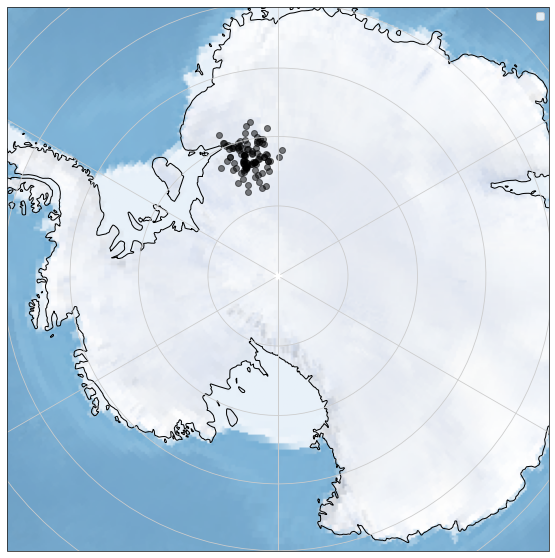

In [23]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon

extent = [-180,180,-70,-70]
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# sns.scatterplot(x = RM_ensembl_quant_plon.mean, y =RM_ensemble_quant_plat.mean,
                
#                 transform = ccrs.PlateCarree())
plt.scatter(plott.plon, plott.plat,transform = ccrs.Geodetic(), color = "black", alpha = 0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()